In [49]:
import os
import ast
import glob
import json
import ineqpy
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from collections import defaultdict
from pathlib import Path

In [50]:
path_data = Path("../data")
path_meta = Path("../meta")

font_size = 15

platform_abbreviation_mapping = {
    'gh': 'GitHub',
    'hf': 'Hugging Face Spaces',
    'pwc': 'Papers With Code',
    'ip': 'independent platform',
}

platform_abbreviation_mapping_inverse = {v: k for k, v in platform_abbreviation_mapping.items()}

leaderboard_organization_tactics_mapping = {
    'Algorithm': ['Algorithm'],
    'Evaluation Configuration': ['Dataset Slice', 'Evaluator', 'Metric'],
    'Leaderboard Aggregation': ['Aggregated Result'],
    'Leaderboard Release': ['Leaderboard Launch Date', 'Leaderboard Version'],
    'Model Capability': ['Benchmark Dataset', 'Service Load', 'Supported Functionality', 'Supported Language', 'Supported Modality', 'Task'],
    'Model Information': ['Model Accessibility', 'Model Size', 'Model Type'],
    'Prompt Engineering': ['#Prompt Example', 'Output Length', 'Prompt Design', 'Prompt Length', 'Relation Extractor', 'Tokenizer']
}

pwc_organization_strategies = {'Task'}

submission_avenue_synonyms = {
    'Competition': ['Hackathon']
}

leaderboard_without_evaluation_datasets = ['Hackathon Somos NLP 2023 Leaderboard', 'Somos NLP Likes Leaderboard', 'Ko Chatbot Arena Leaderboard']

leaderboard_without_pull_requests = ['FSMBench', 'CompMix', 'DocVQA', 'GENIE', 'InfographicVQA', 'LMExamQA', 'Models Leaderboard', 'MP-DocVQA', 'OpenEval (text)', 'Program Synthesis Models Leaderboard', 'ProtoQA', 'TextSynth Server']

leaderboard_without_contacts = ['OpenEval (text)']

leaderboard_without_documentation = ['Hackathon Somos NLP 2023 Leaderboard', 'Somos NLP Likes Leaderboard', 'FSMBench']

leaderboard_without_evaluation_harness = ['Hackathon Somos NLP 2023 Leaderboard', 'Somos NLP Likes Leaderboard', 'LLM-Leaderboard']

workflow_patterns_with_submission = ['4', '5', '6', '7']

macro_presentation_format_mapping = {
    'Table': ['Regular Table', 'Sortable Table', 'Table Screenshot'],
    'Figure': ['Bar Chart', 'Box Plot', 'Heat Map', 'Line Chart', 'Pie Chart', 'Radar Chart', 'Scatter Plot', 'Sortable Bar Chart'],
}

organizer_synonyms = {
    'Alibaba Group': ['Alibaba Group DAMO Academy', 'Aliyun'],
    'Amazon': ['Amazon Alexa AI Lab', 'Amazon AWS AI Lab'],
    'Agency for Science Technology and Research': ['A*STAR I2R', 'CFAR A*STAR'],
    'Bauhaus University': ['Bauhaus University Weimar'],
    'ByteDance': ['ByteDance AI Lab'],
    'Fraunhofer Society': ['Fraunhofer Institute for Integrated Circuits'],
    'Frédéric Joliot Institute for Life Sciences': ['NeuroSpin'],
    'Google': ['Google Brain', 'Google DeepMind', 'Google Blueshift'],
    'Huawei': ["Huawei Noah's Ark Lab"],
    'Kunlun Tech': ['Skywork'],
    'Max Planck Society': ['Max Planck Institute for Informatics', 'Max Planck Institute for Intelligent Systems', 'Max Planck Institute for Mathematics in the Sciences'],
    'Meta': [
        'Meta FAIR',
        'Meta GenAI'
    ],
    'Microsoft': ['Microsoft Research Asia'],
    'National Public School': ['National Public School HSR Layout'],
    'Naver': ['Naver Labs Europe'],
    'Queen\'s University Kingston': ['Queen\'s University'],
    'Tencent': [
        'Tencent AI Lab',
        'Tencent ARC Lab',
        'Tencent Youtu Lab'
    ],
    'Toyota Technological Institute': ['Toyota Technological Institute Chicago'],
    'University of California': [
        'University of California Berkeley',
        'University of California Los Angeles',
        'University of California Santa Barbara',
        'University of California San Diego',
        'University of California Irvine',
    ],
    'University of Michigan': ['University of Michigan Ann Arbor'],
    'University of North Carolina': ['University of North Carolina Chapel Hill'],
    'University of Illinois': ['University of Illinois Chicago', 'University of Illinois Urbana Champaign'],
    'University of Massachusetts': ['University of Massachusetts Amherst'],
    'University of Maryland': ['University of Maryland College Park'],
    'University of Tennessee': ['University of Tennessee Knoxville'],
    'University of Texas': ['University of Texas Austin'],
    'University of Wisconsin': ['University of Wisconsin Madison'],
}

metrics_synonyms = {
    'accuracy': [
        'acc',
        'accuarcy',
        'qa accuracy'
    ],
    'average': [
        'avg',
        '平均'
    ],
    'average accuracy': [
        'avg. accuracy'
    ],
    'average score': ['平均分'],
    'bleu': ['bleu score'],
    'bleu-1': [
        'narrativeqa bleu-1',
        'socialiqa bleu-1',
        'mcscript bleu-1',
        'cosmosqa bleu-1'
    ],
    'bleu-4': ['bleu4'],
    'bertscore': ['bert score'],
    'code': ['代码'],
    'elo rating': [
        'chatbot arena elo',
        'elo'
    ],
    'exact match': ['em', 'exact match accuracy'],
    'lerc': [
        'cosmosqa lerc',
        'mcscript lerc',
        'socialiqa lerc',
        'narrativeqa lerc'
    ],
    'link': ['url'],
    'mean rank': [
        'text-to-video mean rank',
        'video-to-text mean rank'
    ],
    'median rank': [
        'text-to-video median rank',
        'video-to-text median rank',
        'text-to-videomedian rank',
        'text-to-video medianr'
    ],
    'meteor': [
        'cosmosqa meteor',
        'narrativeqa meteor',
        'socialiqa meteor',
        'mcscript meteor'
    ],
    'neg mean rank': [
        'i->t neg mean rank',
        't->i neg mean rank'
    ],
    'organization': [
        '发布机构',
        '机构',
        'orgaisation',
    ],
    'others': ['其他'],
    'overall': ['xiezhi overall'],
    'overall score': [
        '总分',
        '总体分数'
    ],
    'pass@1': [
        'interview pass@1',
        'competition pass@1',
        'introductory pass@1'
    ],
    'pass@5': [
        'interview pass@5',
        'introductory pass@5',
        'competition pass@5'
    ],
    'pass@1000': [
        'interview pass@1000',
        'competition pass@1000',
        'introductory pass@1000'
    ],
    'pass@any': [
        'introductory pass@any',
        'competition pass@any',
        'interview pass@any'
    ],
    '#parameters':  [
        '#p',
        '#params',
        '# params',
        '#size',
        '参数量',
        'model size',
        'model size/b',
        'number of params',
        'param',
        'parameters',
        'params',
        'size'
    ],
    'perplexity': ['ppl'],
    'precision@1': ['i->t p@1'],
    'precision@20': ['p@20'],
    'recall@1': [
        'r@1',
        'text-to-videor@1',
        'video-to-text r@1',
        'text-to-video r@1',
        'text-to-image r@1',
        'image-to-text r@1'
    ],
    'recall@5': [
        'text-to-image r@5',
        'video-to-text r@5',
        'image-to-text r@5',
        'text-to-video r@5',
        'r@5',
    ],
    'recall@10': [
        'recall@10 on 1 rounds',
        'recall@10 on 2 rounds',
        'recall@10 on 3 rounds',
        'r@10',
        'video-to-text r@10',
        'text-to-image r@10',
        'text-to-video r@10',
        'image-to-text r@10'
    ],
    'recall@50': [
        'text-to-video r@50',
        'video-to-text r@50',
    ],
    'score': ['分数'],
    'submission date': ['提交时间'],
    'top-1 accuracy': ['top 1 accuracy'],
    'top-5 accuracy': ['top 5 accuracy'],
    'type': ['model type'],
    'win rate': ['胜率'],
    'word error rate': ['wer']
}

# model_naming_convention = {
#     'Model Publisher (first line)': [
#         'Provider Leaderboard'
#     ],
#     'Repository Username': [
#         'EQ-Bench (v2)',
#         'HHEM Leaderboard',
#         'Big Code Models Leaderboard',
#         'Colossal-AI',
#         'DecodingTrust',
#         'LLMPerf Leaderboard',
#         'LLM-Perf Leaderboard',
#         'Open LLM Leaderboard',
#         'Open Ko-LLM Leaderboard',
#         'ScandEval',
#         'RewardBench',
#     ],
# }

presentation_format_pwc = ['Sortable Table', 'Scatter Plot']
dashed_model_leaderboards = ['MMCU', 'SuperCLUE-Math6']
non_literature_type = ['blog', 'report', 'white paper']

metrics_synonyms_inverse = {}
for key, values in metrics_synonyms.items():
    for value in values:
        metrics_synonyms_inverse[value] = key

submission_avenue_synonyms_inverse = {}
for key, values in submission_avenue_synonyms.items():
    for value in values:
        submission_avenue_synonyms_inverse[value] = key

macro_presentation_format_mapping_inverse = {v: k for k, values in macro_presentation_format_mapping.items() for v in values}

organizer_synonyms_inverse = {}
for key, values in organizer_synonyms.items():
    for value in values:
        organizer_synonyms_inverse[value] = key

leaderboard_organization_tactics_mapping_inverse = {}
for key, values in leaderboard_organization_tactics_mapping.items():
    for value in values:
        leaderboard_organization_tactics_mapping_inverse[value] = key

# model_naming_convention_count = {
#     k: len(v) for k, v in model_naming_convention.items()}

def convert_df_to_dict(df):
    """
    Convert a DataFrame of leaderboards and metrics to a dictionary.

    :param df: DataFrame with leaderboards and metrics
    :return: Dictionary with leaderboards as keys and list of metrics as values
    """
    leaderboard_data = {}

    # Ensure the DataFrame's first column is considered as the keys
    # and iterate through each row to construct the dictionary
    for _, row in df.iterrows():
        key = row[0]  # The first column serves as the key
        # List comprehension to get non-empty values from the rest of the row
        values = [value for value in row[1:] if pd.notna(value)]
        leaderboard_data[key] = values

    return leaderboard_data


def string_to_list(text, platform=False):
    if pd.isna(text):
        return []
    elif platform:
        return [platform_abbreviation_mapping[platform] for platform in text.split(',')]
    else:
        return text.split(',')


def string_to_dict(s, platform=False):
    # Check if the input is np.nan
    if pd.isna(s):
        return {}
    # Split the string into key-value pairs
    pairs = s.split(',')
    result_dict = {}
    for pair in pairs:
        # Split each pair by ':' to separate keys and values
        key, value = pair.split(':')
        # Split the value by '+' to get the list of items
        value_list = value.split('+')
        # Assign the list to the key in the dictionary
        if platform:
            result_dict[platform_abbreviation_mapping[key]] = value_list
        else:
            result_dict[key] = value_list
    return result_dict


# Function to format each value based on its own decimal places
def format_individual_value(x):
    if isinstance(x, float):
        # Use string formatting to maintain original decimal places
        return "{:f}".format(x).rstrip('0').rstrip('.')
    return x


def print_empty_folders(root_dir):
    for dirpath, dirname, filenames in os.walk(root_dir):
        # Check if both lists of subdirectories and filenames are empty
        if not filenames and dirpath != root_dir:
            print(f"Empty folder: {dirpath}")


# def process_model(model_str):
#     if '](' in model_str:
#         model_str = model_str.split('](')[0][1:]
        
#     # # Substrings to be removed
#     # substrings_to_remove = ['🥇', '🥈', '🥉', '🗒️', '📄', '🌍', '✨', '💙', '💚', '†', '*']
    
#     # # Remove each unwanted substring
#     # for substring in substrings_to_remove:
#     #     model_str = model_str.replace(substring, '')
#     import re    
#     model_str = re.sub(r'\\u[0-9A-Fa-f]{4}', '', model_str)
        
#     model_str = model_str.replace('_', '-').strip()
        
#     return model_str
    

def list_directories(folder_path):
    # List all subdirectories within the folder
    directories = [os.path.join(folder_path, d) for d in os.listdir(
        folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    return directories


def organizer_synonyms_mapping(organizers):
    organizers_processed = set()
    for organizer in organizers:
        if organizer in organizer_synonyms_inverse:
            organizers_processed.add(organizer_synonyms_inverse[organizer])
        # elif 'Independent Contributor' == organizer:
        #     organizers_processed.add(leaderboard)
        else:
            organizers_processed.add(organizer)
    return organizers_processed

def submission_avenue_synonyms_mapping(submission_avenue):
    submission_avenue_processed = set()
    for avenue in submission_avenue:
        if avenue in submission_avenue_synonyms_inverse:
            submission_avenue_processed.add(submission_avenue_synonyms_inverse[avenue])
        else:
            submission_avenue_processed.add(avenue)
    return submission_avenue_processed

def keep_rows_by_list_column(df, column_name, keyword_list):
    """
    Filters rows in a DataFrame based on whether all elements in a specified list column are in a given keyword list.
    
    Parameters:
    - df: Pandas DataFrame.
    - column_name: The name of the column containing lists of strings.
    - keyword_list: A list of keywords to check against.
    
    Returns:
    - A filtered Pandas DataFrame.
    """
    # Convert the keyword list to a set for faster membership testing
    keyword_set = set(keyword_list)
    
    # Define a lambda function to check if all elements of a list are in the keyword_set
    all_in_keywords = lambda x: all(item in keyword_set for item in x)
    
    # Apply the lambda function to the specified column and invert the boolean Series to filter rows
    filtered_df = df[df[column_name].apply(all_in_keywords)]
    
    return filtered_df

def filter_rows_by_list_column(df, column_name, keyword_list):
    """
    Filters rows in a DataFrame based on whether all elements in a specified list column are in a given keyword list.
    
    Parameters:
    - df: Pandas DataFrame.
    - column_name: The name of the column containing lists of strings.
    - keyword_list: A list of keywords to check against.
    
    Returns:
    - A filtered Pandas DataFrame.
    """
    # Convert the keyword list to a set for faster membership testing
    keyword_set = set(keyword_list)
    
    # Define a lambda function to check if all elements of a list are in the keyword_set
    all_in_keywords = lambda x: all(item in keyword_set for item in x)
    
    # Apply the lambda function to the specified column and invert the boolean Series to filter rows
    filtered_df = df[~df[column_name].apply(all_in_keywords)]
    
    return filtered_df

In [51]:
xlsx = pd.ExcelFile(path_meta / 'Foundation Model Leaderboard Systems.xlsx')
df_leaderboard = pd.read_excel(xlsx, sheet_name='Leaderboard System')

for index, row in df_leaderboard.iterrows():
    os.makedirs(path_data / row['Leaderboard name'], exist_ok=True) 

print_empty_folders(str(path_data))

In [52]:
directory = path_data / "CyberSafetyEval"
channel = ''
drop_columns = []

for file_path in glob.glob(str(directory / "*.csv")):
    df = pd.read_csv(file_path)#, delimiter=";")
    df.drop(columns=drop_columns, inplace=True)
    filename = os.path.basename(file_path)
    filename = filename.replace(".csv", ".json")
    if channel:
        filename = f'{channel}-{filename}'
    df.to_json(directory / filename, orient="records", indent=4)
    os.remove(file_path)


In [53]:
# # Aligning Model Names for Standardized Analysis 
# for directory in os.listdir(path_data):
#     subdirectory_path = os.path.join(path_data, directory)
#     for file in glob.glob(os.path.join(subdirectory_path, "*.json")):
#         try:
#             df = pd.read_json(file)
#             df['Model'] = df['Model'].apply(process_model)
#             df.to_json(file, orient='records', indent=4)
#             break
#         except:
#             print(file)


In [54]:
# with pd.ExcelFile(path_meta / 'Foundation Model Leaderboard Systems.xlsx') as xlsx:
#     df_benchmark = xlsx.parse('Benchmark')
#     benchmark_mapping = convert_df_to_dict(df_benchmark)
#     leaderboard_benchmarks = set()
#     for key in benchmark_mapping.keys():
#         benchmarks = [benchmark.split(' (')[0] for benchmark in benchmark_mapping[key]]
#         leaderboard_benchmarks = leaderboard_benchmarks.union(set(benchmarks))
#     print('Total number of benchmarks:', len(leaderboard_benchmarks))

In [55]:
# with pd.ExcelFile(path_meta / 'Foundation Model Leaderboard Systems.xlsx') as excel_file:
#     df_leaderboard = pd.read_excel(excel_file, sheet_name='Leaderboard System')
#     df_leaderboard['Platforms'] = df_leaderboard['Platforms'].apply(lambda x: string_to_list(x, platform=True))
#     df_leaderboard['Presentation formats (non-pwc)'] = df_leaderboard['Presentation formats (non-pwc)'].apply(lambda x: string_to_dict(x, platform=True))
#     for index, row in df_leaderboard.iterrows():
#         platforms = row['Platforms']
#         if 'Papers With Code' in platforms:
#             continue
#         platforms_dict = row['Presentation formats (non-pwc)'].keys()
#         if set(platforms).difference(platforms_dict):
#             print(row['Leaderboard name'], platforms, platforms_dict)

In [56]:
total_records = 0
total_leaderboards = 0
total_leaderboard_systems = 0

with pd.ExcelFile(path_meta / 'Foundation Model Leaderboard Systems.xlsx') as excel_file:
    df_leaderboard = pd.read_excel(excel_file, sheet_name='Leaderboard System')

    df_leaderboard['Downloadable format'] = df_leaderboard['Downloadable format'].apply(string_to_list)
    df_leaderboard['Evaluation workflows (non-pwc)'] = df_leaderboard['Evaluation workflows (non-pwc)'].astype(str).apply(string_to_list)
    # df_leaderboard['Organization strategies (non-pwc)'] = df_leaderboard['Organization strategies (non-pwc)'].apply(string_to_list)
    df_leaderboard['Platforms'] = df_leaderboard['Platforms'].apply(lambda x: string_to_list(x, platform=True))
    df_leaderboard['Presentation formats (non-pwc)'] = df_leaderboard['Presentation formats (non-pwc)'].apply(lambda x: string_to_dict(x, platform=True))
    df_leaderboard['Publication venues'] = df_leaderboard['Publication venues'].apply(string_to_list)
    df_leaderboard['Release organizations (non-pwc)'] = df_leaderboard['Release organizations (non-pwc)'].apply(string_to_list)
    # df_leaderboard['Submission channels (non-pwc)'] = df_leaderboard['Submission channels (non-pwc)'].apply(string_to_list)
    # df_leaderboard['Supported languages'] = df_leaderboard['Supported languages'].apply(string_to_list)
    # df_leaderboard['Supported modalities'] = df_leaderboard['Supported modalities'].apply(string_to_list)

    df_leaderboard['Participating models'] = [set() for _ in range(len(df_leaderboard))]
    df_leaderboard['Evaluation metrics (pwc)'] = [set() for _ in range(len(df_leaderboard))]
    # df_leaderboard['Organization strategies'] = [set() for _ in range(len(df_leaderboard))]
    df_leaderboard['Release organizations'] = [set() for _ in range(len(df_leaderboard))]
    # df_leaderboard['Supported benchmarks'] = [set() for _ in range(len(df_leaderboard))]

    # df_benchmark = pd.read_excel(excel_file, sheet_name='Benchmark')
    # benchmark_mapping = convert_df_to_dict(df_benchmark)
    # for key, values in benchmark_mapping.items():
    #     benchmark_mapping[key] = list(set([value.split(' (')[0] for value in values]))

    for index, row in df_leaderboard.iterrows():
        total_leaderboard_systems += 1
        
        # if row['Leaderboard name'] == 'MTEB':
        #     benchmarks = benchmark_mapping['MTEB'] + benchmark_mapping['CMTEB']
        # elif row['Leaderboard name'] in benchmark_mapping:
        #     benchmarks = benchmark_mapping[row['Leaderboard name']]
        # else:
        #     benchmarks = [row['Leaderboard name'].split(' (')[0]]
        # df_leaderboard.at[index, 'Supported benchmarks'] = benchmarks
        # df_leaderboard.at[index, '#Supported benchmark'] = len(benchmarks)

        presentation_formats = set()
        organizers = organizer_synonyms_mapping(row['Release organizations (non-pwc)'])
        # organization_strategies = row['Organization strategies (non-pwc)']
        presentation_formats_mapping = row['Presentation formats (non-pwc)']
        # submission_avenues = submission_avenue_synonyms_mapping(row['Submission channels (non-pwc)'])
        for key, values in presentation_formats_mapping.items():
            presentation_formats = presentation_formats.union(set(values))
        if row['Platforms'] == ['Papers With Code']:
            organizers.add('Papers With Code')
            # organization_strategies = pwc_organization_strategies.union(organization_strategies)
            presentation_formats = presentation_formats.union(presentation_format_pwc)
            presentation_formats_mapping['Papers With Code'] = presentation_format_pwc
        
        df_leaderboard.at[index, '#Presentation format'] = len(presentation_formats)
        # df_leaderboard.at[index, '#Organization strategy'] = len(organization_strategies)
        df_leaderboard.at[index, '#Release organization'] = len(organizers)
        # df_leaderboard.at[index, 'Organization strategies'] = organization_strategies
        df_leaderboard.at[index, 'Release organizations'] = organizers
        # df_leaderboard.at[index, 'Submission channels (non-pwc)'] = submission_avenues
    
        df_leaderboard.at[index, '#Host platform'] = len(row['Platforms'])
        # df_leaderboard.at[index, '#Supported language'] = len(row['Supported languages'])
        # df_leaderboard.at[index, '#Supported modality'] = len(row['Supported modalities'])

        records = 0
        leaderboards = 0
        model_names = set()
        template_metrics = set()
    
        for file in os.listdir(path_data / row['Leaderboard name']):
            host_platform = platform_abbreviation_mapping[file.split('.')[0].split('-')[0]]
            if host_platform not in row['Platforms']:
                continue
        
            file_path = path_data / row['Leaderboard name'] / file
            df = pd.read_json(file_path)
        
            leaderboards += 1
            records += len(df)
        
            # df['Model'] = df['Model'].apply(lambda x: x.split('/')[-1])
            # df['Model'] = df['Model'].apply(lambda x: x.split('\n')[0].split('(')[0].strip())
            model_names = model_names.union(set(df['Model']))
        
            file_name = file.split('/')[-1]
            if file_name.startswith('pwc'):
                keys = set()
                for item in df['metrics']:
                    for key in item.keys():
                        key_processed = key.split('(')[0].lower().strip()
                        if key_processed in metrics_synonyms_inverse:
                            keys.add(metrics_synonyms_inverse[key_processed])
                        else:
                            keys.add(key_processed)
                template_metrics = template_metrics.union(keys)
            # else:
            #     column_size = len(df.columns)
            #     if column_size == 2:
            #         print(f"{file_path}: {df.at[0, 'Model']}")
    
        total_records += records
        total_leaderboards += leaderboards
        
        df_leaderboard.at[index, '#Evaluation record'] = records
        df_leaderboard.at[index, '#Participating model'] = len(model_names)
        # df_leaderboard.at[index, 'Participating models'] = list(model_names)
        df_leaderboard.at[index, '#Leaderboard'] = leaderboards
        if template_metrics:
            df_leaderboard.at[index, '#Evaluation metric (pwc)'] = len(template_metrics)
            df_leaderboard.at[index, 'Evaluation metrics (pwc)'] = list(template_metrics)
        
    df_leaderboard.to_csv(path_meta / 'leaderboard_processed.csv', index=False)

print(f"Total number of leaderboard systems: {total_leaderboard_systems}")
print(f"Total number of leaderboards: {total_leaderboards}")
print(f"Total number of evaluation records: {total_records}")


Total number of leaderboard systems: 432
Total number of leaderboards: 2843
Total number of evaluation records: 79353


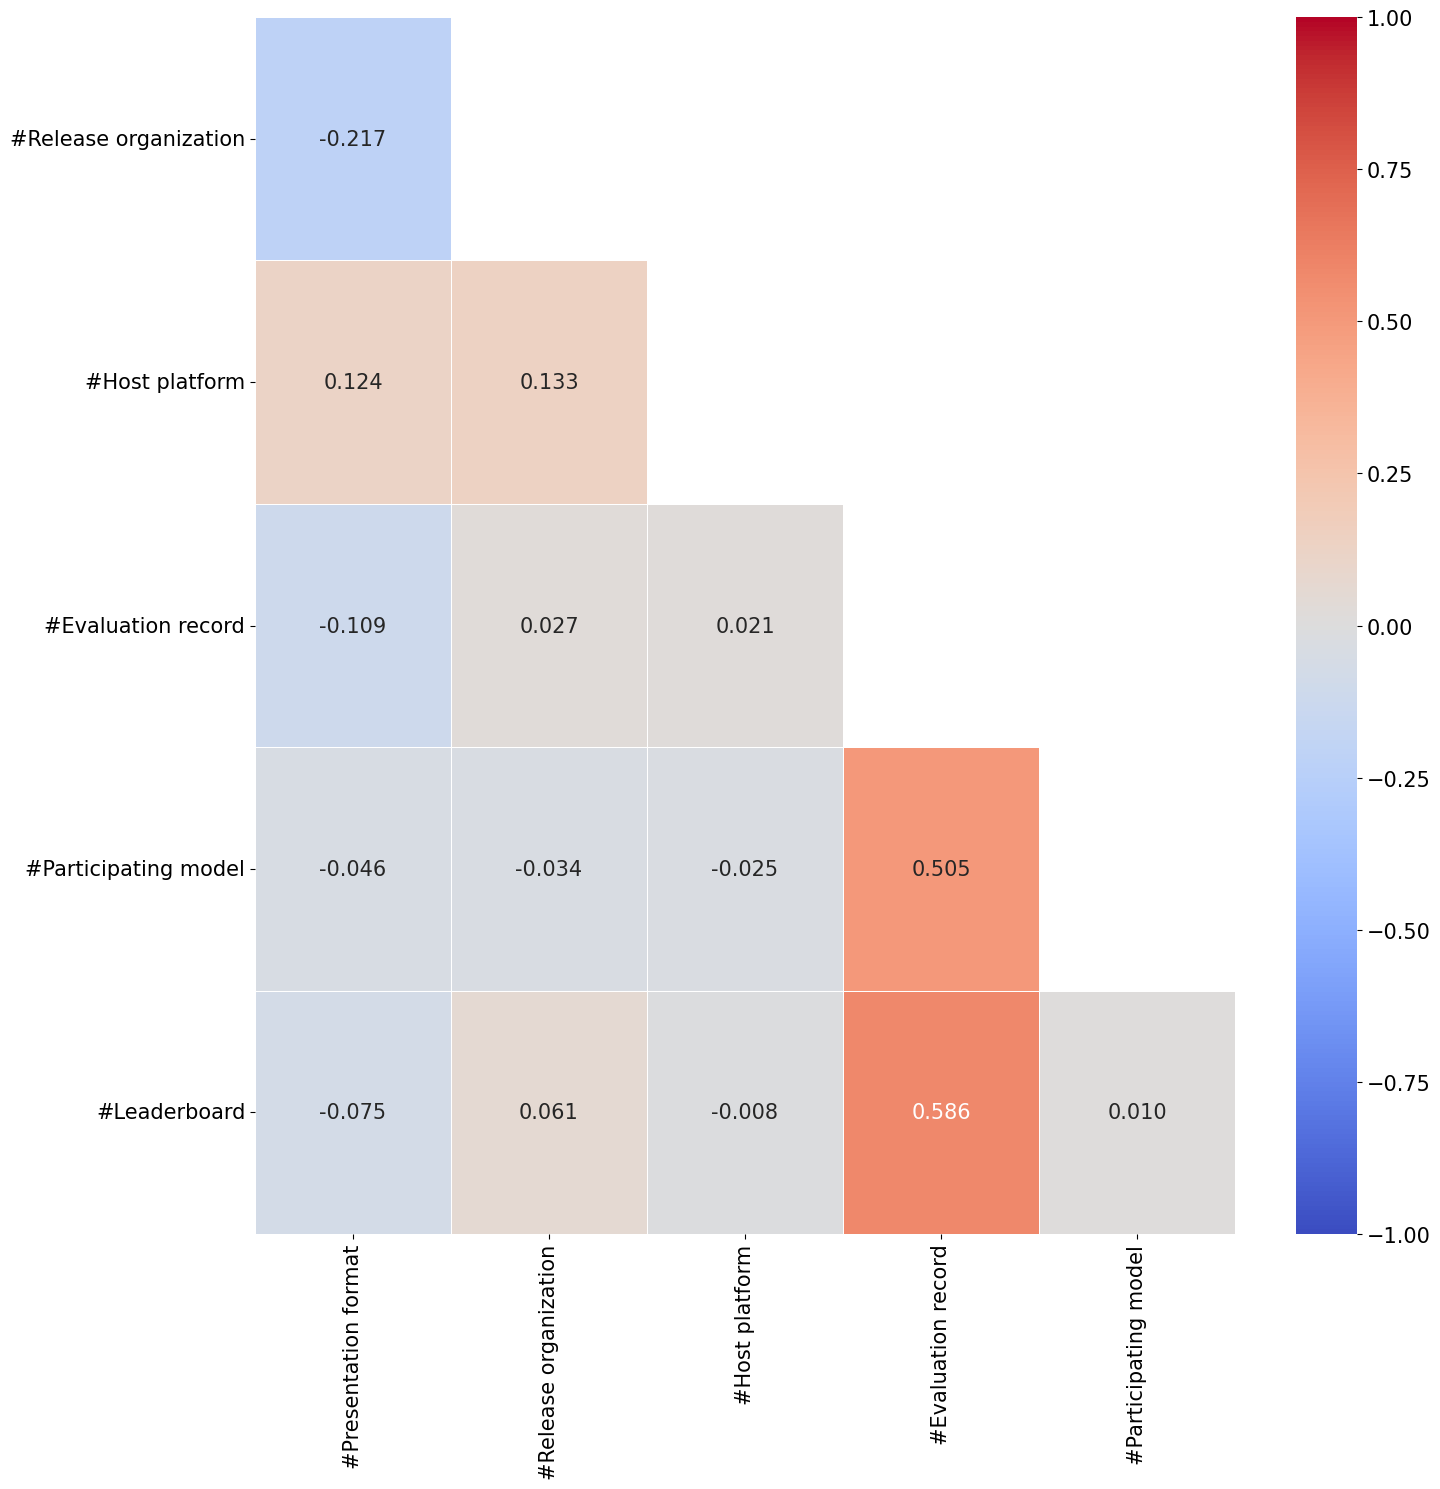

In [57]:
df = pd.read_csv(path_meta / 'leaderboard_processed.csv')
numeric_df = df.select_dtypes(include=['float64', 'int64'])
numeric_df = numeric_df.drop(columns=['#Evaluation metric (pwc)'])
corr_matrix = numeric_df.corr()

# Drop the first row
corr_matrix_dropped_row = corr_matrix.drop(corr_matrix.index[0])

# Drop the last column
corr_matrix_dropped = corr_matrix_dropped_row.drop(corr_matrix_dropped_row.columns[-1], axis=1)

# Generate a mask for the upper triangle, including the diagonal
mask = np.triu(np.ones_like(corr_matrix_dropped, dtype=bool), 1)

# Generate a heatmap for the correlation matrix with the mask
plt.figure(figsize=(15,15))
ax = sns.heatmap(corr_matrix_dropped, annot=True, cmap='coolwarm', fmt=".3f", linewidths=.5, mask=mask, vmin=-1, vmax=1, annot_kws={"size": font_size})
# Enlarge axis font size
ax.tick_params(axis='both', which='major', labelsize=font_size)
# Rotate y-axis labels to horizontal
ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 
ax.set_xticklabels(ax.get_xticklabels(), rotation=90) 
# Adjust color bar (color scale) font size
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=font_size)  # Adjusts the tick labels' font size

plt.tight_layout()  # Adjust the layout to make sure everything fits
plt.savefig(path_meta / 'leaderboard-attribute-heatmap.pdf', format='pdf')
plt.show()


In [58]:
df = pd.read_csv(path_meta / 'leaderboard_processed.csv')
df['Platforms'] = df['Platforms'].apply(ast.literal_eval)
print(f"{round(len(df[df['Platforms'].map(len) > 1])/len(df)*100,2)}% ({len(df[df['Platforms'].map(len) > 1])} out of {len(df)}) leaderboard systems are hosted on multiple platforms.")

df_split = df.explode('Platforms')['Platforms'].value_counts().reset_index(name='Frequency')
print(f"{df_split['Platforms'].iloc[0]} is the most popular host platform, accounting for {round(df_split['Frequency'].iloc[0]/len(df)*100,2)}% ({df_split['Frequency'].iloc[0]} out of {len(df)}) leaderboards.")
df_split['Weight'] = 1

statistics = {
    'Distribution': 'Leaderboard Systems across Platforms',
    'Mean': np.mean(df_split['Frequency']),
    'Median': np.median(df_split['Frequency']),
    'IQR': df_split['Frequency'].quantile(0.75) - df_split['Frequency'].quantile(0.25),
    'Gini Coefficient': ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'),
}
df_statistics = pd.read_csv(path_meta / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_meta / 'leaderboard_statistics.csv', index=False)

df_split['Ratio'] = round(df_split['Frequency'] / len(df) * 100, 2)

fig = px.bar(
    x=df_split['Platforms'],
    y=df_split['Ratio'],
    text_auto=True,
    labels={'x': 'Platforms', 'y': 'Number of Leaderboards'},
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()

11.57% (50 out of 432) leaderboard systems are hosted on multiple platforms.
Papers With Code is the most popular host platform, accounting for 44.68% (193 out of 432) leaderboards.


FileNotFoundError: [Errno 2] No such file or directory: '..\\meta\\leaderboard_statistics.csv'

Regular Table is the most prevalent presentation format in leaderboards hosted on GitHub, accounting for 71.54% (88 out of 123) leaderboards.
Sortable Table is the most prevalent presentation format in leaderboards hosted on Hugging Face Spaces, accounting for 97.73% (86 out of 88) leaderboards.
Sortable Table is the most prevalent presentation format in leaderboards hosted on Papers With Code, accounting for 97.93% (189 out of 193) leaderboards.
Sortable Table is the most prevalent presentation format in leaderboards hosted on independent platform, accounting for 70.37% (57 out of 81) leaderboards.


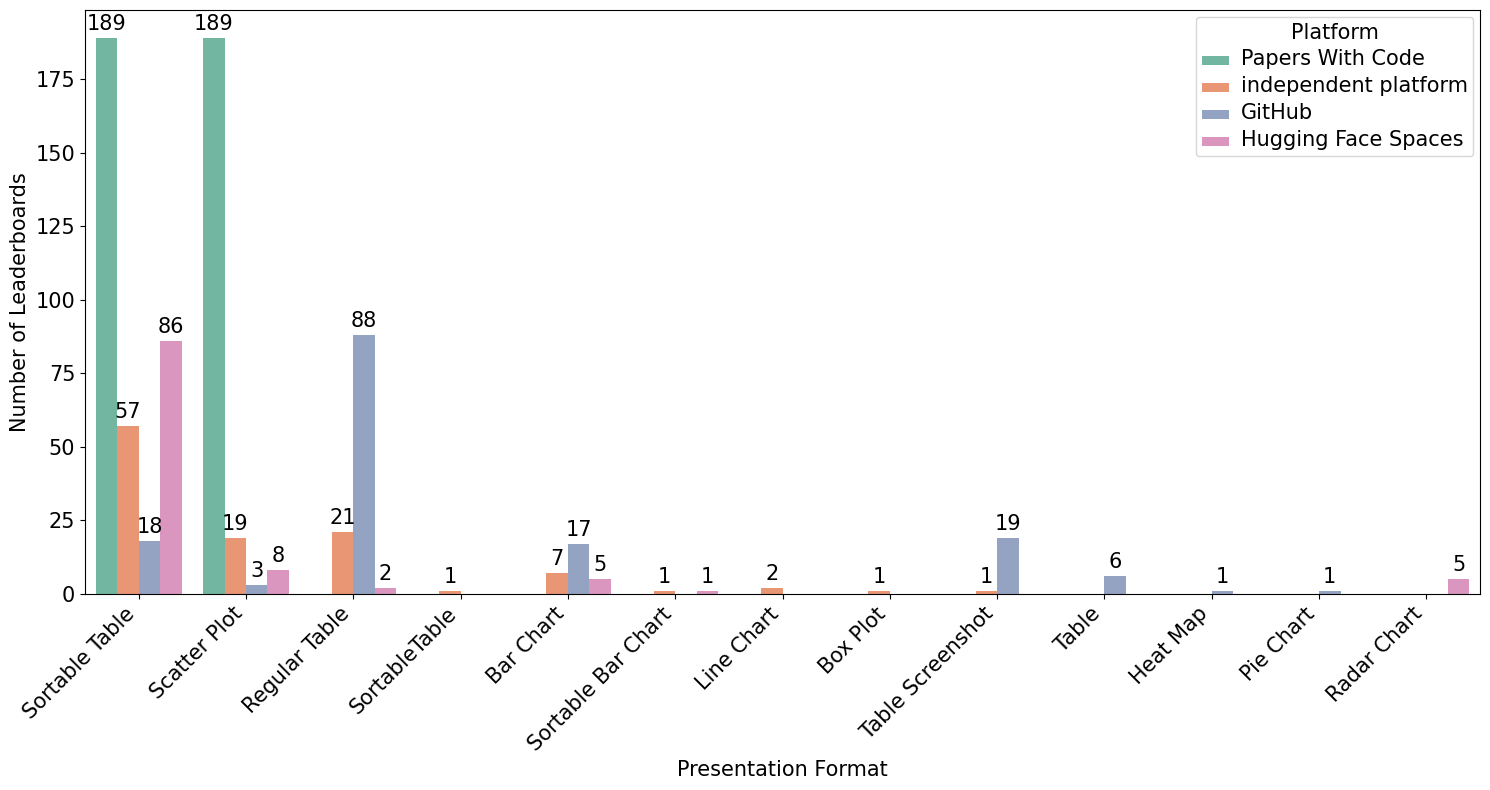

In [ ]:
df = pd.read_csv(path_meta / 'leaderboard_processed.csv')
df['Presentation formats (non-pwc)'] = df['Presentation formats (non-pwc)'].apply(ast.literal_eval)
df['Platforms'] = df['Platforms'].apply(ast.literal_eval)

format_counts = defaultdict(lambda: defaultdict(int))
for index, row in df.iterrows():
    # Loop through each platform and its formats in the dictionary
    for platform, formats in row['Presentation formats (non-pwc)'].items():
        for format_type in formats:
            # Increment the count for the format type under its respective platform
            format_counts[platform][format_type] += 1
            
flattened_data = []
for platform, formats in format_counts.items():
    for format_type, count in formats.items():
        flattened_data.append({'Platform': platform, 'Presentation Format': format_type, 'Frequency': count})
        
df_presentation = pd.DataFrame(flattened_data)
df = df.explode('Platforms')
for name, group in df_presentation.groupby('Platform'):
    group = group.sort_values(by='Frequency', ascending=False)
    print(f"{group['Presentation Format'].iloc[0]} is the most prevalent presentation format in leaderboards hosted on {name}, accounting for {round(group['Frequency'].iloc[0]/len(df[df['Platforms'] == name])*100,2)}% ({group['Frequency'].iloc[0]} out of {len(df[df['Platforms'] == name])}) leaderboards.")

# Plotting
plt.figure(figsize=(15, 8))  # Adjust figure size as needed
ax = sns.barplot(
    x='Presentation Format', 
    y='Frequency', 
    hue='Platform',  # This separates the bars within each group by platform
    data=df_presentation, 
    palette='Set2',  # Choose a palette that makes the bars distinct
    dodge=True  # Adjust this to control the gap between bars of different platforms within the same group
)

# Setting the title and labels with enlarged fonts
ax.set_xlabel('Presentation Format', fontsize=font_size)  # Enlarge x-axis label
ax.set_ylabel('Number of Leaderboards', fontsize=font_size)  # Enlarge y-axis label
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Enlarge axis ticks font size
ax.tick_params(axis='both', which='major', labelsize=font_size)

# Adding annotations on top of each bar
for p in ax.patches:
    if p.get_height():
        ax.annotate(format(p.get_height(), '.0f'),  # Format the number presentationed
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position
                ha = 'center', va = 'center', 
                xytext = (0, 10),  # Distance from the top of the bar
                textcoords = 'offset points', fontsize=font_size)

# Adjust the legend
leg = ax.legend(title='Platform')
leg.set_title('Platform', prop={'size':font_size})  # Set the title font size
for text in leg.get_texts():  # Set the font size for each legend text
    text.set_fontsize(font_size)
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
# Save the plot to a PDF file
plt.savefig(path_meta / 'presentation-format-distribution.pdf', bbox_inches='tight')
plt.show()

df_split = df_presentation.groupby('Presentation Format').sum().reset_index()
df_split['Weight'] = 1

statistics = {
    'Distribution': 'Leaderboard Systems across Presentation Formats',
    'Mean': np.mean(df_split['Frequency']),
    'Median': np.median(df_split['Frequency']),
    'IQR': df_split['Frequency'].quantile(0.75) - df_split['Frequency'].quantile(0.25),
    'Gini Coefficient': ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'),
}
if os.path.exists(path_meta / 'leaderboard_statistics.csv'):
    df_statistics = pd.read_csv(path_meta / 'leaderboard_statistics.csv')
else:
    df_statistics = pd.DataFrame()
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_meta / 'leaderboard_statistics.csv', index=False)


In [ ]:
# df = pd.read_csv(path_meta / 'leaderboard_processed.csv')

# statistics = {
#     'Distribution': 'Presentation Formats across Leaderboard Systems',
#     'Mean': np.mean(df['#Presentation format']),
#     'Median': np.median(df['#Presentation format']),
#     'IQR': df['#Presentation format'].quantile(0.75) - df['#Presentation format'].quantile(0.25),
# }
# df_statistics = pd.read_csv(path_meta / 'leaderboard_statistics.csv')
# df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
# df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
# df_statistics.sort_values(by='Distribution', inplace=True)
# df_statistics.to_csv(path_meta / 'leaderboard_statistics.csv', index=False)

# df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Presentation format', ascending=False).head(15)
# print(f"{df_top['Leaderboard name'].iloc[0]} supports the highest number of presentation formats up to {int(df_top['#Presentation format'].iloc[0])}.")

# fig = go.Figure(go.Bar(
#         x=df_top['#Presentation format'],  # Values for the bar lengths
#         y=df_top['Leaderboard name'],  # Categories for each bar
#         orientation='h',  # Sets the bars to be horizontal
#         text=df_top['#Presentation format'],  # Adds the values as text on each bar
#         textposition='auto'  # Automatically positions the text on the bars
# ))
# fig.update_layout(
#         xaxis_title='Number of Presentation Format',
#         yaxis_title='Leaderboard Name',
#         yaxis_autorange='reversed'  # This line makes the bars go top-down
# )
# # Update the layout for a tighter look
# fig.update_layout(
#     autosize=True,
#     margin=dict(
#         l=10,  # Left margin
#         r=10,  # Right margin
#         b=10,  # Bottom margin
#         t=10,  # Top margin
#         pad=4  # Padding between the plot and the margin
#     )
# )
# fig.show()

Models Leaderboard supports the highest number of presentation formats up to 5.


In [ ]:
df = pd.read_csv(path_meta / 'leaderboard_processed.csv')
df['Downloadable format'] = df['Downloadable format'].apply(ast.literal_eval)
print(f"{round(len(df[df['Downloadable format'].map(len) > 0])/len(df)*100,2)}% ({len(df[df['Downloadable format'].map(len) > 0])} out of {len(df)}) leaderboard systems provide downloadable format of the leaderboards.")

df = df[df['Downloadable format'].map(len) > 0]
df_split = df.explode('Downloadable format')['Downloadable format'].value_counts().reset_index(name='Frequency')
print(f"{df_split['Downloadable format'].iloc[0]} is the most popular storage format of leaderboards, accounting for {round(df_split['Frequency'].iloc[0]/len(df)*100,2)}% ({df_split['Frequency'].iloc[0]} out of {len(df)}) downloadable leaderboard systems.")
df_split['Weight'] = 1

statistics = {
    'Distribution': 'Leaderboard Systems across Downloadable Formats',
    'Mean': np.mean(df_split['Frequency']),
    'Median': np.median(df_split['Frequency']),
    'IQR': df_split['Frequency'].quantile(0.75) - df_split['Frequency'].quantile(0.25),
    'Gini Coefficient': ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'),
}
df_statistics = pd.read_csv(path_meta / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_meta / 'leaderboard_statistics.csv', index=False)

df_split['Ratio'] = round(df_split['Frequency'] / len(df) * 100, 2)

fig = px.bar(
    x=df_split['Downloadable format'],
    y=df_split['Ratio'],
    text_auto=True,
    labels={'x': 'Downloadable format', 'y': 'Number of Leaderboards'},
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()

12.96% (56 out of 432) leaderboard systems provide downloadable format of the leaderboards.
CSV is the most popular storage format of leaderboards, accounting for 78.57% (44 out of 56) downloadable leaderboard systems.


In [ ]:
# df = pd.read_csv(path_meta / 'leaderboard_processed.csv')

# statistics = {
#     'Distribution': 'Platforms across Leaderboard Systems',
#     'Mean': np.mean(df['#Host platform']),
#     'Median': np.median(df['#Host platform']),
#     'IQR': df['#Host platform'].quantile(0.75) - df['#Host platform'].quantile(0.25),
# }
# df_statistics = pd.read_csv(path_meta / 'leaderboard_statistics.csv')
# df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
# df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
# df_statistics.sort_values(by='Distribution', inplace=True)
# df_statistics.to_csv(path_meta / 'leaderboard_statistics.csv', index=False)

# df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Host platform', ascending=False).head(10)
# print(f"{df_top['Leaderboard name'].iloc[0]} is hosted by the highest number of platforms up to {int(df_top['#Host platform'].iloc[0])}.")

# fig = go.Figure(go.Bar(
#         x=df_top['#Host platform'],  # Values for the bar lengths
#         y=df_top['Leaderboard name'],  # Categories for each bar
#         orientation='h',  # Sets the bars to be horizontal
#         text=df_top['#Host platform'],  # Adds the values as text on each bar
#         textposition='auto'  # Automatically positions the text on the bars
# ))
# fig.update_layout(
#         xaxis_title='Number of Platforms',
#         yaxis_title='Leaderboard Name',
#         yaxis_autorange='reversed'  # This line makes the bars go top-down
# )
# # Update the layout for a tighter look
# fig.update_layout(
#     autosize=True,
#     margin=dict(
#         l=10,  # Left margin
#         r=10,  # Right margin
#         b=10,  # Bottom margin
#         t=10,  # Top margin
#         pad=4  # Padding between the plot and the margin
#     )
# )
# fig.show()

MTEB is hosted by the highest number of platforms up to 4.


In [ ]:
df = pd.read_csv(path_meta / 'leaderboard_processed.csv')

df['Release organizations'] = df['Release organizations'].apply(ast.literal_eval)
df_split = df.explode('Release organizations').groupby('Release organizations').size().reset_index(name='Frequency')
df_split['Weight'] = 1

statistics = {
    'Distribution': 'Leaderboard Systems across Release Organizations',
    'Mean': np.mean(df_split['Frequency']),
    'Median': np.median(df_split['Frequency']),
    'IQR': df_split['Frequency'].quantile(0.75) - df_split['Frequency'].quantile(0.25),
    'Gini Coefficient': ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'),
}
df_statistics = pd.read_csv(path_meta / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_meta / 'leaderboard_statistics.csv', index=False)

df_top = df_split.sort_values(by='Frequency', ascending=False).head(10)
print(f"{df_top['Release organizations'].iloc[0]} stands out as the most prolific release organization among the {len(df_split['Release organizations'].unique())} identified, contributing to a notable {round(df_top['Frequency'].iloc[0]/len(df)*100,2)}% ({df_top['Frequency'].iloc[0]} out of {len(df)}) leaderboard systems.")

df_top['Ratio'] = round(df_top['Frequency'] / len(df) * 100, 2)

fig = go.Figure(go.Bar(
        x=df_top['Frequency'],  # Values for the bar lengths
        y=df_top['Release organizations'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['Ratio'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        title=f'Number of Leaderboard Systems across Release Organizations (Top 10)',
        xaxis_title='Leaderboard Number',
        yaxis_title='Publisher Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
fig.show()


Papers With Code stands out as the most prolific release organization among the 235 identified, contributing to a notable 43.75% (189 out of 432) leaderboard systems.


In [ ]:
df = pd.read_csv(path_meta / 'leaderboard_processed.csv')
df = df[df['Platforms'] != "['Papers With Code']"]

statistics = {
    'Distribution': 'Release Organizations across Leaderboard Systems',
    'Mean': np.mean(df['#Release organization']),
    'Median': np.median(df['#Release organization']),
    'IQR': df['#Release organization'].quantile(0.75) - df['#Release organization'].quantile(0.25),
}
df_statistics = pd.read_csv(path_meta / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_meta / 'leaderboard_statistics.csv', index=False)

df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Release organization', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} holds the highest number of release organizations up to {int(df_top['#Release organization'].iloc[0])}.")

fig = go.Figure(go.Bar(
        x=df_top['#Release organization'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Release organization'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Number of Release Organization',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()


TrustLLM holds the highest number of release organizations up to 36.


In [ ]:
df = pd.read_csv(path_meta / 'leaderboard_processed.csv')
df['Publication venues'] = df['Publication venues'].apply(ast.literal_eval)
df_pub = df[df['Publication venues'].apply(len) > 0]
print(f"{round(len(df_pub)/len(df)*100,2)}% ({len(df_pub)} out of {len(df)}) leaderboard systems are associated with specific publications, including research papers, blog posts, and articles.")

df_literature = filter_rows_by_list_column(df_pub, 'Publication venues', non_literature_type)
print(f"{round(len(df_literature)/len(df)*100,2)}% ({len(df_literature)} out of {len(df)}) publications have been accepted in a specific workshop, conference, magzine, or journal.")
df_split = df_literature.explode('Publication venues').groupby('Publication venues').size().reset_index(name='Frequency')
df_split['Weight'] = 1

statistics = {
    'Distribution': 'Leaderboard Systems across Publication Venues',
    'Mean': np.mean(df_split['Frequency']),
    'Median': np.median(df_split['Frequency']),
    'IQR': df_split['Frequency'].quantile(0.75) - df_split['Frequency'].quantile(0.25),
    'Gini Coefficient': ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'),
}
df_statistics = pd.read_csv(path_meta / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_meta / 'leaderboard_statistics.csv', index=False)

df_top = df_split.sort_values(by='Frequency', ascending=False).head(10)
print(f"{df_top['Publication venues'].iloc[0]} emerges as the conference with the most number of accepted publications, accounting for {round(df_top['Frequency'].iloc[0]/len(df_literature)*100,2)}% ({df_top['Frequency'].iloc[0]} out of {len(df_literature)}) of those published.")

df_top['Ratio'] = round(df_top['Frequency'] / len(df_literature) * 100, 2)

fig = go.Figure(go.Bar(
        x=df_top['Frequency'],  # Values for the bar lengths
        y=df_top['Publication venues'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['Ratio'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        title=f'Number of Leaderboards with Accepted Publications across Publication Venues (Top 10)',
        xaxis_title='Leaderboard Number',
        yaxis_title='Publication Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
fig.show()


85.88% (371 out of 432) leaderboard systems are associated with specific publications, including research papers, blog posts, and articles.
53.7% (232 out of 432) publications have been accepted in a specific workshop, conference, magzine, or journal.
EMNLP emerges as the conference with the most number of accepted publications, accounting for 16.81% (39 out of 232) of those published.


In [ ]:
# df = pd.read_csv(path_meta / 'leaderboard_processed.csv')
# df_split = df[df['#Organization strategy'] > 0]
# print(f'{round(len(df_split)/len(df)*100,2)}% ({len(df_split)} out of {len(df)}) non-pwc leaderboards have adopted multiple organization strategies.')

# statistics = {
#     'Distribution': 'Organization Strategies across Leaderboard Systems',
#     'Mean': np.mean(df_split['#Organization strategy']),
#     'Median': np.median(df_split['#Organization strategy']),
#     'IQR': df_split['#Organization strategy'].quantile(0.75) - df_split['#Organization strategy'].quantile(0.25),
# }
# df_statistics = pd.read_csv(path_meta / 'leaderboard_statistics.csv')
# df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
# df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
# df_statistics.sort_values(by='Distribution', inplace=True)
# df_statistics.to_csv(path_meta / 'leaderboard_statistics.csv', index=False)

# df_top = df_split.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Organization strategy', ascending=False).head(10)
# print(f"{df_top['Leaderboard name'].iloc[0]} has adopted the highest number of organization strategies up to {int(df_top['#Organization strategy'].iloc[0])} among non-pwc leaderboards.")

# fig = go.Figure(go.Bar(
#         x=df_top['#Organization strategy'],  # Values for the bar lengths
#         y=df_top['Leaderboard name'],  # Categories for each bar
#         orientation='h',  # Sets the bars to be horizontal
#         text=df_top['#Organization strategy'],  # Adds the values as text on each bar
#         textposition='auto'  # Automatically positions the text on the bars
# ))
# fig.update_layout(
#         xaxis_title='Number of Organization Strategy',
#         yaxis_title='Leaderboard Name',
#         yaxis_autorange='reversed'  # This line makes the bars go top-down
# )
# # Update the layout for a tighter look
# fig.update_layout(
#     autosize=True,
#     margin=dict(
#         l=10,  # Left margin
#         r=10,  # Right margin
#         b=10,  # Bottom margin
#         t=10,  # Top margin
#         pad=4  # Padding between the plot and the margin
#     )
# )
# fig.show()


In [ ]:
# df = pd.read_csv(path_meta / 'leaderboard_processed.csv')
# df = df[df['#Organization strategy'] > 0]

# df['Organization strategies'] = df['Organization strategies'].apply(ast.literal_eval)
# df_split = df.explode('Organization strategies').groupby('Organization strategies').size().reset_index(name='Frequency')
# df_split['Weight'] = 1

# statistics = {
#     'Distribution': 'Leaderboard Systems across Organization Strategies',
#     'Mean': np.mean(df_split['Frequency']),
#     'Median': np.median(df_split['Frequency']),
#     'IQR': df_split['Frequency'].quantile(0.75) - df_split['Frequency'].quantile(0.25),
#     'Gini Coefficient': ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'),
# }
# df_statistics = pd.read_csv(path_meta / 'leaderboard_statistics.csv')
# df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
# df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
# df_statistics.sort_values(by='Distribution', inplace=True)
# df_statistics.to_csv(path_meta / 'leaderboard_statistics.csv', index=False)

# df_top = df_split.sort_values(by='Frequency', ascending=False).head(10)
# print(f"{df_top['Organization strategies'].iloc[0]} is the most adopted organization strategy, involving {round(df_top['Frequency'].iloc[0]/len(df)*100,2)}% ({df_top['Frequency'].iloc[0]} out of {len(df)}) multi-split leaderboard systems.")

# fig = go.Figure(go.Bar(
#         x=df_top['Frequency'],  # Values for the bar lengths
#         y=df_top['Organization strategies'],  # Categories for each bar
#         orientation='h',  # Sets the bars to be horizontal
#         text=df_top['Frequency'],  # Adds the values as text on each bar
#         textposition='auto'  # Automatically positions the text on the bars
# ))
# fig.update_layout(
#         xaxis_title='Leaderboard Number',
#         yaxis_title='Organization Strategy',
#         yaxis_autorange='reversed'  # This line makes the bars go top-down
# )
# # Update the layout for a tighter look
# fig.update_layout(
#     autosize=True,
#     margin=dict(
#         l=10,  # Left margin
#         r=10,  # Right margin
#         b=10,  # Bottom margin
#         t=10,  # Top margin
#         pad=4  # Padding between the plot and the margin
#     )
# )
# fig.show()


In [ ]:
# df = pd.read_csv(path_meta / 'leaderboard_processed.csv')

# statistics = {
#     'Distribution': 'Supported Languages across Leaderboard Systems',
#     'Mean': np.mean(df['#Supported language']),
#     'Median': np.median(df['#Supported language']),
#     'IQR': df['#Supported language'].quantile(0.75) - df['#Supported language'].quantile(0.25),
# }
# df_statistics = pd.read_csv(path_meta / 'leaderboard_statistics.csv')
# df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
# df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
# df_statistics.sort_values(by='Distribution', inplace=True)
# df_statistics.to_csv(path_meta / 'leaderboard_statistics.csv', index=False)

# df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Supported language', ascending=False).head(10)
# print(f"{df_top['Leaderboard name'].iloc[0]} supports the highest number of languages up to {int(df_top['#Supported language'].iloc[0])}.")

# fig = go.Figure(go.Bar(
#         x=df_top['#Supported language'],  # Values for the bar lengths
#         y=df_top['Leaderboard name'],  # Categories for each bar
#         orientation='h',  # Sets the bars to be horizontal
#         text=df_top['#Supported language'],  # Adds the values as text on each bar
#         textposition='auto'  # Automatically positions the text on the bars
# ))
# fig.update_layout(
#         xaxis_title='Number of Supported Languages',
#         yaxis_title='Leaderboard Name',
#         yaxis_autorange='reversed'  # This line makes the bars go top-down
# )
# # Update the layout for a tighter look
# fig.update_layout(
#     autosize=True,
#     margin=dict(
#         l=10,  # Left margin
#         r=10,  # Right margin
#         b=10,  # Bottom margin
#         t=10,  # Top margin
#         pad=4  # Padding between the plot and the margin
#     )
# )
# fig.show()


In [ ]:
# df = pd.read_csv(path_meta / 'leaderboard_processed.csv')
# df['Supported languages'] = df['Supported languages'].apply(ast.literal_eval)

# df_split = df.explode('Supported languages').groupby('Supported languages').size().reset_index(name='Frequency')
# df_split['Weight'] = 1

# statistics = {
#     'Distribution': 'Leaderboard Systems across Supported Languages',
#     'Mean': np.mean(df_split['Frequency']),
#     'Median': np.median(df_split['Frequency']),
#     'IQR': df_split['Frequency'].quantile(0.75) - df_split['Frequency'].quantile(0.25),
#     'Gini Coefficient': ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'),
# }
# df_statistics = pd.read_csv(path_meta / 'leaderboard_statistics.csv')
# df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
# df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
# df_statistics.sort_values(by='Distribution', inplace=True)
# df_statistics.to_csv(path_meta / 'leaderboard_statistics.csv', index=False)

# df_top = df_split.drop_duplicates(subset=['Supported languages']).sort_values(by='Frequency', ascending=False).head(10)
# print(f"{df_top['Supported languages'].iloc[0]} is the language most frequently supported by {round(df_top['Frequency'].iloc[0]/len(df)*100,2)}% ({df_top['Frequency'].iloc[0]} out of {len(df)}) leaderboards.")

# fig = go.Figure(go.Bar(
#         x=df_top['Frequency'],  # Values for the bar lengths
#         y=df_top['Supported languages'],  # Categories for each bar
#         orientation='h',  # Sets the bars to be horizontal
#         text=df_top['Frequency'],  # Adds the values as text on each bar
#         textposition='auto'  # Automatically positions the text on the bars
# ))
# fig.update_layout(
#         xaxis_title='Leaderboard Number',
#         yaxis_title='Supported language',
#         yaxis_autorange='reversed'  # This line makes the bars go top-down
# )
# # Update the layout for a tighter look
# fig.update_layout(
#     autosize=True,
#     margin=dict(
#         l=10,  # Left margin
#         r=10,  # Right margin
#         b=10,  # Bottom margin
#         t=10,  # Top margin
#         pad=4  # Padding between the plot and the margin
#     )
# )
# fig.show()

In [ ]:
# df = pd.read_csv(path_meta / 'leaderboard_processed.csv')

# statistics = {
#     'Distribution': 'Supported Modalities across Leaderboard Systems',
#     'Mean': np.mean(df['#Supported modality']),
#     'Median': np.median(df['#Supported modality']),
#     'IQR': df['#Supported modality'].quantile(0.75) - df['#Supported modality'].quantile(0.25),
# }
# df_statistics = pd.read_csv(path_meta / 'leaderboard_statistics.csv')
# df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
# df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
# df_statistics.sort_values(by='Distribution', inplace=True)
# df_statistics.to_csv(path_meta / 'leaderboard_statistics.csv', index=False)

# df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Supported modality', ascending=False).head(10)
# print(f"{df_top['Leaderboard name'].iloc[0]} supports the highest number of modality up to {int(df_top['#Supported modality'].iloc[0])}.")

# fig = go.Figure(go.Bar(
#         x=df_top['#Supported modality'],  # Values for the bar lengths
#         y=df_top['Leaderboard name'],  # Categories for each bar
#         orientation='h',  # Sets the bars to be horizontal
#         text=df_top['#Supported modality'],  # Adds the values as text on each bar
#         textposition='auto'  # Automatically positions the text on the bars
# ))
# fig.update_layout(
#         xaxis_title='Number of Supported Modality',
#         yaxis_title='Leaderboard Name',
#         yaxis_autorange='reversed'  # This line makes the bars go top-down
# )
# # Update the layout for a tighter look
# fig.update_layout(
#     autosize=True,
#     margin=dict(
#         l=10,  # Left margin
#         r=10,  # Right margin
#         b=10,  # Bottom margin
#         t=10,  # Top margin
#         pad=4  # Padding between the plot and the margin
#     )
# )
# fig.show()


In [ ]:
# df = pd.read_csv(path_meta / 'leaderboard_processed.csv')
# df['Supported modalities'] = df['Supported modalities'].apply(ast.literal_eval)

# df_split = df.explode('Supported modalities').groupby('Supported modalities').size().reset_index(name='Frequency')
# df_split['Weight'] = 1

# statistics = {
#     'Distribution': 'Leaderboard Systems across Supported Modalities',
#     'Mean': np.mean(df_split['Frequency']),
#     'Median': np.median(df_split['Frequency']),
#     'IQR': df_split['Frequency'].quantile(0.75) - df_split['Frequency'].quantile(0.25),
#     'Gini Coefficient': ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'),
# }
# df_statistics = pd.read_csv(path_meta / 'leaderboard_statistics.csv')
# df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
# df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
# df_statistics.sort_values(by='Distribution', inplace=True)
# df_statistics.to_csv(path_meta / 'leaderboard_statistics.csv', index=False)

# df_top = df_split.drop_duplicates(subset=['Supported modalities']).sort_values(by='Frequency', ascending=False).head(10)
# print(f"{df_top['Supported modalities'].iloc[0]} is the most supported modality by {round(df_top['Frequency'].iloc[0]/len(df)*100,2)}% ({df_top['Frequency'].iloc[0]} out of {len(df)}) leaderboards.")

# fig = go.Figure(go.Bar(
#         x=df_top['Frequency'],  # Values for the bar lengths
#         y=df_top['Supported modalities'],  # Categories for each bar
#         orientation='h',  # Sets the bars to be horizontal
#         text=df_top['Frequency'],  # Adds the values as text on each bar
#         textposition='auto'  # Automatically positions the text on the bars
# ))
# fig.update_layout(
#         xaxis_title='Leaderboard Number',
#         yaxis_title='Supported Modality',
#         yaxis_autorange='reversed'  # This line makes the bars go top-down
# )
# # Update the layout for a tighter look
# fig.update_layout(
#     autosize=True,
#     margin=dict(
#         l=10,  # Left margin
#         r=10,  # Right margin
#         b=10,  # Bottom margin
#         t=10,  # Top margin
#         pad=4  # Padding between the plot and the margin
#     )
# )
# fig.show()

In [ ]:
# df = pd.read_csv(path_meta / 'leaderboard_processed.csv')

# statistics = {
#     'Distribution': 'Supported Benchmarks across Leaderboard Systems',
#     'Mean': np.mean(df['#Supported benchmark']),
#     'Median': np.median(df['#Supported benchmark']),
#     'IQR': df['#Supported benchmark'].quantile(0.75) - df['#Supported benchmark'].quantile(0.25),
# }
# df_statistics = pd.read_csv(path_meta / 'leaderboard_statistics.csv')
# df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
# df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
# df_statistics.sort_values(by='Distribution', inplace=True)
# df_statistics.to_csv(path_meta / 'leaderboard_statistics.csv', index=False)

# df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Supported benchmark', ascending=False).head(10)
# print(f"{df_top['Leaderboard name'].iloc[0]} supports the highest number of {int(df_top['#Supported benchmark'].iloc[0])} benchmarks.")

# fig = go.Figure(go.Bar(
#         x=df_top['#Supported benchmark'],  # Values for the bar lengths
#         y=df_top['Leaderboard name'],  # Categories for each bar
#         orientation='h',  # Sets the bars to be horizontal
#         text=df_top['#Supported benchmark'],  # Adds the values as text on each bar
#         textposition='auto'  # Automatically positions the text on the bars
# ))
# fig.update_layout(
#         xaxis_title='Number of Supported Benchmarks',
#         yaxis_title='Leaderboard Name',
#         yaxis_autorange='reversed'  # This line makes the bars go top-down
# )
# # Update the layout for a tighter look
# fig.update_layout(
#     autosize=True,
#     margin=dict(
#         l=10,  # Left margin
#         r=10,  # Right margin
#         b=10,  # Bottom margin
#         t=10,  # Top margin
#         pad=4  # Padding between the plot and the margin
#     )
# )
# fig.show()


In [ ]:
# df = pd.read_csv(path_meta / 'leaderboard_processed.csv')
# df['Supported benchmarks'] = df['Supported benchmarks'].apply(ast.literal_eval)

# df_split = df.explode('Supported benchmarks').groupby('Supported benchmarks').size().reset_index(name='Frequency')
# df_split['Weight'] = 1

# statistics = {
#     'Distribution': 'Leaderboard Systems across Supported Benchmarks',
#     'Mean': np.mean(df_split['Frequency']),
#     'Median': np.median(df_split['Frequency']),
#     'IQR': df_split['Frequency'].quantile(0.75) - df_split['Frequency'].quantile(0.25),
#     'Gini Coefficient': ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'),
# }
# df_statistics = pd.read_csv(path_meta / 'leaderboard_statistics.csv')
# df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
# df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
# df_statistics.sort_values(by='Distribution', inplace=True)
# df_statistics.to_csv(path_meta / 'leaderboard_statistics.csv', index=False)

# df_top = df_split.drop_duplicates(subset=['Supported benchmarks']).sort_values(by='Frequency', ascending=False).head(10)
# print(f"{df_top['Supported benchmarks'].iloc[0]} is the most supported benchmark by {round(df_top['Frequency'].iloc[0]/len(df)*100,2)}% ({df_top['Frequency'].iloc[0]} out of {len(df)}) leaderboards.")

# fig = go.Figure(go.Bar(
#         x=df_top['Frequency'],  # Values for the bar lengths
#         y=df_top['Supported benchmarks'],  # Categories for each bar
#         orientation='h',  # Sets the bars to be horizontal
#         text=df_top['Frequency'],  # Adds the values as text on each bar
#         textposition='auto'  # Automatically positions the text on the bars
# ))
# fig.update_layout(
#         xaxis_title='Leaderboard Number',
#         yaxis_title='Supported Benchmark',
#         yaxis_autorange='reversed'  # This line makes the bars go top-down
# )
# # Update the layout for a tighter look
# fig.update_layout(
#     autosize=True,
#     margin=dict(
#         l=10,  # Left margin
#         r=10,  # Right margin
#         b=10,  # Bottom margin
#         t=10,  # Top margin
#         pad=4  # Padding between the plot and the margin
#     )
# )
# fig.show()

In [ ]:
df = pd.read_csv(path_meta / 'leaderboard_processed.csv')

statistics = {
    'Distribution': 'Participating Models across Leaderboard Systems',
    'Mean': np.mean(df['#Participating model']),
    'Median': np.median(df['#Participating model']),
    'IQR': df['#Participating model'].quantile(0.75) - df['#Participating model'].quantile(0.25),
}
df_statistics = pd.read_csv(path_meta / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_meta / 'leaderboard_statistics.csv', index=False)

df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Participating model', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} has the highest number of {int(df_top['#Participating model'].iloc[0])} participating models.")

fig = go.Figure(go.Bar(
        x=df_top['#Participating model'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Participating model'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Number of Participating Models',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()


Open LLM Leaderboard (GPT) has the highest number of 5485 participating models.


In [ ]:
# df = pd.read_csv(path_meta / 'leaderboard_processed.csv')
# df['Participating models'] = df['Participating models'].apply(ast.literal_eval)

# df_split = df.explode('Participating models').groupby('Participating models').size().reset_index(name='Frequency')
# df_split['Weight'] = 1

# statistics = {
#     'Distribution': 'Leaderboard Systems across Participating Models',
#     'Mean': np.mean(df_split['Frequency']),
#     'Median': np.median(df_split['Frequency']),
#     'IQR': df_split['Frequency'].quantile(0.75) - df_split['Frequency'].quantile(0.25),
#     'Gini Coefficient': ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'),
# }
# df_statistics = pd.read_csv(path_meta / 'leaderboard_statistics.csv')
# df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
# df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
# df_statistics.sort_values(by='Distribution', inplace=True)
# df_statistics.to_csv(path_meta / 'leaderboard_statistics.csv', index=False)

# df_top = df_split.drop_duplicates(subset=['Participating models']).sort_values(by='Frequency', ascending=False).head(10)
# print(f"{df_top['Participating models'].iloc[0]} is the most prevalent participating model in {round(df_top['Frequency'].iloc[0]/len(df)*100,2)}% ({df_top['Frequency'].iloc[0]} out of {len(df)}) leaderboards.")

# fig = go.Figure(go.Bar(
#         x=df_top['Frequency'],  # Values for the bar lengths
#         y=df_top['Participating models'],  # Categories for each bar
#         orientation='h',  # Sets the bars to be horizontal
#         text=df_top['Frequency'],  # Adds the values as text on each bar
#         textposition='auto'  # Automatically positions the text on the bars
# ))
# fig.update_layout(
#         xaxis_title='Leaderboard Number',
#         yaxis_title='Participating Model',
#         yaxis_autorange='reversed'  # This line makes the bars go top-down
# )
# # Update the layout for a tighter look
# fig.update_layout(
#     autosize=True,
#     margin=dict(
#         l=10,  # Left margin
#         r=10,  # Right margin
#         b=10,  # Bottom margin
#         t=10,  # Top margin
#         pad=4  # Padding between the plot and the margin
#     )
# )
# fig.show()

In [ ]:
df = pd.read_csv(path_meta / 'leaderboard_processed.csv')
df = df[df['Platforms'] == "['Papers With Code']"]

statistics = {
    'Distribution': 'Evaluation Metrics across Leaderboard Systems',
    'Mean': np.mean(df['#Evaluation metric (pwc)']),
    'Median': np.median(df['#Evaluation metric (pwc)']),
    'IQR': df['#Evaluation metric (pwc)'].quantile(0.75) - df['#Evaluation metric (pwc)'].quantile(0.25),
}
df_statistics = pd.read_csv(path_meta / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_meta / 'leaderboard_statistics.csv', index=False)

df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Evaluation metric (pwc)', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} has the highest number of {int(df_top['#Evaluation metric (pwc)'].iloc[0])} evaluation metrics.")

fig = go.Figure(go.Bar(
        x=df_top['#Evaluation metric (pwc)'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Evaluation metric (pwc)'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Number of Evaluation Metrics',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()


ChEBI-20 has the highest number of 20 evaluation metrics.


In [ ]:
df = pd.read_csv(path_meta / 'leaderboard_processed.csv')
df = df[df['Platforms'] == "['Papers With Code']"]
df['Evaluation metrics (pwc)'] = df['Evaluation metrics (pwc)'].apply(ast.literal_eval)

df_split = df.explode('Evaluation metrics (pwc)').groupby('Evaluation metrics (pwc)').size().reset_index(name='Frequency')
df_split['Weight'] = 1

statistics = {
    'Distribution': 'Leaderboard Systems across Evaluation Metrics',
    'Mean': np.mean(df_split['Frequency']),
    'Median': np.median(df_split['Frequency']),
    'IQR': df_split['Frequency'].quantile(0.75) - df_split['Frequency'].quantile(0.25),
    'Gini Coefficient': ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'),
}
df_statistics = pd.read_csv(path_meta / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_meta / 'leaderboard_statistics.csv', index=False)

df_top = df_split.drop_duplicates(subset=['Evaluation metrics (pwc)']).sort_values(by='Frequency', ascending=False).head(10)
print(f"{df_top['Evaluation metrics (pwc)'].iloc[0]} is the most prevalent evaluation metrics in {round(df_top['Frequency'].iloc[0]/len(df)*100,2)}% ({df_top['Frequency'].iloc[0]} out of {len(df)}) leaderboards.")

fig = go.Figure(go.Bar(
        x=df_top['Frequency'],  # Values for the bar lengths
        y=df_top['Evaluation metrics (pwc)'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['Frequency'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Leaderboard Number',
        yaxis_title='Evaluation Metric',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()

accuracy is the most prevalent evaluation metrics in 41.27% (78 out of 189) leaderboards.


In [ ]:
df = pd.read_csv(path_meta / 'leaderboard_processed.csv')
df['Weight'] = 1

statistics = {
    'Distribution': 'Leaderboards across Leaderboard Systems',
    'Mean': np.mean(df['#Leaderboard']),
    'Median': np.median(df['#Leaderboard']),
    'IQR': df['#Leaderboard'].quantile(0.75) - df['#Leaderboard'].quantile(0.25),
    'Gini Coefficient': ineqpy.inequality.gini(data=df, income='#Leaderboard', weights='Weight'),
}
df_statistics = pd.read_csv(path_meta / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_meta / 'leaderboard_statistics.csv', index=False)

df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Leaderboard', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} has the highest number of {int(df_top['#Leaderboard'].iloc[0])} leaderboards.")

fig = go.Figure(go.Bar(
        x=df_top['#Leaderboard'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Leaderboard'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Split Number',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()


LMExamQA has the highest number of 887 leaderboards.


In [ ]:
df = pd.read_csv(path_meta / 'leaderboard_processed.csv')
df['Weight'] = 1

statistics = {
    'Distribution': 'Evaluation Records across Leaderboard Systems',
    'Mean': np.mean(df['#Evaluation record']),
    'Median': np.median(df['#Evaluation record']),
    'IQR': df['#Evaluation record'].quantile(0.75) - df['#Evaluation record'].quantile(0.25),
    'Gini Coefficient': ineqpy.inequality.gini(data=df, income='#Evaluation record', weights='Weight'),
}
df_statistics = pd.read_csv(path_meta / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_meta / 'leaderboard_statistics.csv', index=False)

df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Evaluation record', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} has the highest number of {int(df_top['#Evaluation record'].iloc[0])} evaluation records.")

fig = go.Figure(go.Bar(
        x=df_top['#Evaluation record'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Evaluation record'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Number of Evaluation Records',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()


HELM Classic has the highest number of 16005 evaluation records.


In [ ]:
df = pd.read_csv(path_meta / 'leaderboard_processed.csv')
df = df[df['Platforms'] != "['Papers With Code']"]
df['Evaluation workflows (non-pwc)'] = df['Evaluation workflows (non-pwc)'].apply(ast.literal_eval)

df = df[df['Evaluation workflows (non-pwc)'].map(len) > 0]
df_workflow = df.explode('Evaluation workflows (non-pwc)')
df_workflow = df_workflow.groupby('Evaluation workflows (non-pwc)').size().reset_index(name='Frequency')
df_workflow['Evaluation workflows (non-pwc)'] = df_workflow['Evaluation workflows (non-pwc)'].apply(lambda x: f'Pattern {x}' if x != 'Unknown' else x)
df_workflow.sort_values(by='Frequency', ascending=False, inplace=True)
df_workflow['Weight'] = 1

statistics = {
    'Distribution': 'Leaderboard Systems across Evaluation Workflows',
    'Mean': np.mean(df_workflow['Frequency']),
    'Median': np.median(df_workflow['Frequency']),
    'IQR': df_workflow['Frequency'].quantile(0.75) - df_workflow['Frequency'].quantile(0.25),
    'Gini Coefficient': ineqpy.inequality.gini(data=df_workflow, income='Frequency', weights='Weight'),
}
df_statistics = pd.read_csv(path_meta / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution', inplace=True)
df_statistics.to_csv(path_meta / 'leaderboard_statistics.csv', index=False)

print(f"{df_workflow['Evaluation workflows (non-pwc)'].iloc[0]} is the most prevalent ({df_workflow['Frequency'].iloc[0]} out of {len(df)}) workflow pattern that accounts for {round(df_workflow['Frequency'].iloc[0]/len(df)*100,2)}%.")

df_workflow['Ratio'] = round(df_workflow['Frequency'] / len(df) * 100, 2)

fig = px.bar(
    x=df_workflow['Evaluation workflows (non-pwc)'], 
    y=df_workflow['Ratio'],
    text_auto=True,
    labels={'x': 'Evaluation workflows (non-pwc)', 'y': 'Leaderboard Number'},
    title='Number of Leaderboard Systems across Evaluation Workflows (non-pwc)'
)
fig.show()

Pattern 2 is the most prevalent (102 out of 243) workflow pattern that accounts for 41.98%.


In [ ]:
df = pd.read_csv(path_meta / 'leaderboard_processed.csv')
df['Evaluation workflows (non-pwc)'] = df['Evaluation workflows (non-pwc)'].apply(ast.literal_eval)
print(f"{round((len(df)-len(leaderboard_without_documentation))/(len(df))*100, 2)}% ({len(df)-len(leaderboard_without_documentation)} out of {len(df)}) leaderboard systems have documentation.")
print(f"{round((len(df)-len(leaderboard_without_contacts))/(len(df))*100, 2)}% ({len(df)-len(leaderboard_without_contacts)} out of {len(df)}) leaderboard systems have at least one type of contact information.")
print(f"{round((len(df)-len(leaderboard_without_evaluation_datasets))/(len(df))*100, 2)}% ({len(df)-len(leaderboard_without_evaluation_datasets)} out of {len(df)}) leaderboard systems have at least one evaluation dataset.")
df = df[df['Platforms'] != "['Papers With Code']"]
df_submission = keep_rows_by_list_column(df, 'Evaluation workflows (non-pwc)', workflow_patterns_with_submission)
print(f"{round(len(df_submission)/(len(df))*100, 2)}% ({len(df_submission)} out of {len(df)}) non-pwc leaderboard systems provide at least one submission channel.")
print(f"{round((len(df)-len(leaderboard_without_evaluation_harness))/(len(df))*100, 2)}% ({len(df)-len(leaderboard_without_evaluation_harness)} out of {len(df)}) non-pwc leaderboard systems provide evaluation harness.")
print(f"{round((len(df)-len(leaderboard_without_pull_requests))/(len(df))*100, 2)}% ({len(df)-len(leaderboard_without_pull_requests)} out of {len(df)}) non-pwc leaderboard systems provide pull request channels.")
print(f"{round((len(df)-len(leaderboard_without_pull_requests))/(len(df))*100, 2)}% ({len(df)-len(leaderboard_without_pull_requests)} out of {len(df)}) non-pwc leaderboard systems provide discussion forums.")

99.31% (429 out of 432) leaderboard systems have documentation.
99.77% (431 out of 432) leaderboard systems have at least one type of contact information.
99.31% (429 out of 432) leaderboard systems have at least one evaluation dataset.
51.85% (126 out of 243) non-pwc leaderboard systems provide at least one submission channel.
98.77% (240 out of 243) non-pwc leaderboard systems provide evaluation harness.
95.06% (231 out of 243) non-pwc leaderboard systems provide pull request channels.
95.06% (231 out of 243) non-pwc leaderboard systems provide discussion forums.


In [ ]:
df = pd.read_csv(path_meta / 'leaderboard_processed.csv')
df = df[df['Platforms'] == "['Papers With Code']"]

total = 0
evalai = 0
huggingface = 0
paperswithcode = 0

for root, dirs, files in os.walk(path_data):
    for file in files:
        if file.startswith('pwc') and file.endswith(".json"):
            with open(os.path.join(root, file), 'r') as file:
                total += 1
                for external in json.load(file):
                    if type(external['external_source_url']) != str:
                        paperswithcode += 1
                        break
                    elif 'eval.ai' in external['external_source_url']:
                        evalai += 1 
                        break
                    elif 'huggingface.co' in external['external_source_url']:  
                        huggingface += 1
                        break
                    
pwc_workflow_pattern_mapping = {
    'Workflow Pattern 7': f'{round(paperswithcode/total*100, 2)}% ({paperswithcode} out of {total})',
    'Workflow Pattern 8': f'{round((huggingface + evalai)/total*100, 2)}% ({huggingface + evalai} out of {total}))'
}
pwc_workflow_pattern_mapping

{'Workflow Pattern 7': '68.3% (459 out of 672)',
 'Workflow Pattern 8': '31.7% (213 out of 672))'}

In [ ]:
df = pd.read_csv(path_meta / 'leaderboard_processed.csv')
print(f"{round(len(df[df['#Empty leaderboards (non-pwc)'].notna()])/len(df)*100,2)}% ({len(df[df['#Empty leaderboards (non-pwc)'].notna()])} out of {len(df)}) leaderboard systems have empty leaderboards.")
df['#Empty leaderboards (non-pwc)'].value_counts().reset_index(name='Frequency')

1.16% (5 out of 432) leaderboard systems have empty leaderboards.


,#Empty leaderboards (non-pwc),Frequency
0,2,2
1,Unknown,2
2,25,1


In [ ]:
# df = pd.read_csv(path_meta / 'leaderboard_processed.csv')
# df = df[df['Platforms'] != "['Papers With Code']"]
# print(f'There are {len(df)} non-pwc leaderboard systems.')

# df['Evaluation workflows (non-pwc)'] = df['Evaluation workflows (non-pwc)'].apply(ast.literal_eval)
# df['Submission channels (non-pwc)'] = df['Submission channels (non-pwc)'].apply(ast.literal_eval)
# df_submission = df[df['Submission channels (non-pwc)'].map(len) > 0]
# print(f"{round(len(df_submission)/len(df)*100,2)}% ({len(df_submission)} out of {len(df)}) leaderboards provide at least one submission & collection guideline for new evaluation records.")

# df_split = df_submission.explode('Evaluation workflows (non-pwc)').explode('Submission channels (non-pwc)')
# df_split = df_split.groupby(['Evaluation workflows (non-pwc)', 'Submission channels (non-pwc)']).size().reset_index(name='Frequency')
# df_split.sort_values(by=['Evaluation workflows (non-pwc)', 'Submission channels (non-pwc)'], inplace=True)

# df_split['Evaluation workflows (non-pwc)'] = df_split['Evaluation workflows (non-pwc)'].apply(lambda x: f'Pattern {x}' if x != 'Unknown' else x)
# df_avenue = df_split.groupby('Submission channels (non-pwc)').sum().reset_index()
# df_avenue.sort_values(by='Frequency', ascending=False, inplace=True)
# df_avenue['Weight'] = 1

# statistics = {
#     'Distribution': 'Leaderboard Systems across Submission & Collection Avenues',
#     'Mean': np.mean(df_avenue['Frequency']),
#     'Median': np.median(df_avenue['Frequency']),
#     'IQR': df_avenue['Frequency'].quantile(0.75) - df_avenue['Frequency'].quantile(0.25),
#     'Gini Coefficient': ineqpy.inequality.gini(data=df_avenue, income='Frequency', weights='Weight'),
# }
# df_statistics = pd.read_csv(path_meta / 'leaderboard_statistics.csv')
# df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
# df_statistics.drop_duplicates(subset=['Distribution'], keep='last', inplace=True)
# df_statistics.sort_values(by='Distribution', inplace=True)
# df_statistics.to_csv(path_meta / 'leaderboard_statistics.csv', index=False)

# fig = px.bar(
#     x=df_avenue['Submission channels (non-pwc)'], 
#     y=df_avenue['Frequency'],
#     text_auto=True,
#     labels={'x': 'Submission channels (non-pwc)', 'y': 'Leaderboard Number'},
#     title='Number of Leaderboard Systems across Submission & Collection Avenues (non-pwc)'
# )
# fig.show()

# df_split = df_split[df_split['Evaluation workflows (non-pwc)'] != 'Unknown']
# for name, group in df_split.groupby('Evaluation workflows (non-pwc)'):
#     group = group.sort_values(by='Frequency', ascending=False)
#     print(f"{group['Submission channels (non-pwc)'].iloc[0]} is the most prevalent avenue in evaluation workflow {name}, accounting for {round(group['Frequency'].iloc[0]/group['Frequency'].sum()*100,2)}% ({group['Frequency'].iloc[0]} out of {group['Frequency'].sum()}) leaderboard systems.")

# # Plotting
# plt.figure(figsize=(15, 8))  # Adjust figure size as needed
# ax = sns.barplot(
#     x='Evaluation workflows (non-pwc)', 
#     y='Frequency', 
#     hue='Submission channels (non-pwc)',  # This separates the bars within each group by platform
#     data=df_split, 
#     palette='Set2',  # Choose a palette that makes the bars distinct
#     dodge=True  # Adjust this to control the gap between bars of different platforms within the same group
# )

# # Setting the title and labels with enlarged fonts
# ax.set_xlabel('Workflow Pattern', fontsize=font_size)  # Enlarge x-axis label
# ax.set_ylabel('Number of Leaderboards', fontsize=font_size)  # Enlarge y-axis label
# plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# # Enlarge axis ticks font size
# ax.tick_params(axis='both', which='major', labelsize=font_size)

# # Adding annotations on top of each bar
# for p in ax.patches:
#     if p.get_height():
#         ax.annotate(format(p.get_height(), '.0f'),  # Format the number presentationed
#                 (p.get_x() + p.get_width() / 2., p.get_height()),  # Position
#                 ha = 'center', va = 'center', 
#                 xytext = (0, 10),  # Distance from the top of the bar
#                 textcoords = 'offset points', fontsize=font_size)

# # Adjust the legend
# leg = ax.legend(title='Submisstion Avenue')
# leg.set_title('Platform', prop={'size':font_size})  # Set the title font size
# for text in leg.get_texts():  # Set the font size for each legend text
#     text.set_fontsize(font_size)
# plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
# # Save the plot to a PDF file
# plt.savefig(path_meta / 'workflow-pattern-distribution.pdf', bbox_inches='tight')
# plt.show()

In [ ]:
# df = pd.read_csv(path_meta / 'leaderboard_processed.csv')
# df = df[~df['Platforms'].str.contains('GitHub|Papers With Code')]
# df['Feedback venues (hf+ip)'] = df['Feedback venues (hf+ip)'].apply(ast.literal_eval)

# df_hf = df[df['Platforms'].str.contains('Hugging Face')]
# print(f'There are {len(df_hf)} leaderboards hosted on Hugging Face.')
# df_hf = df_hf.explode('Feedback venues (hf+ip)')['Feedback venues (hf+ip)'].value_counts().reset_index(name='Frequency')
# print(df_hf)

# df_ip = df[df['Platforms'].str.contains('independent platform')]
# print(f'There are {len(df_ip)} leaderboards hosted on independent platforms.')
# df_ip = df_ip.explode('Feedback venues (hf+ip)')['Feedback venues (hf+ip)'].value_counts().reset_index(name='Frequency')
# print(df_ip)

In [ ]:
# df = pd.read_csv(path_meta / 'leaderboard_processed.csv')
# df = df[df['Platforms'] != "['Papers With Code']"]
# df_structure = df[df['#Organization strategy'] > 0]
# print(f'There are {len(df_structure)} non-pwc leaderboards that have adopted organization strategies, accounting for {round(len(df_structure)/len(df)*100,2)}% of the total.')
# df_structure['Organization strategies'] = df_structure['Organization strategies'].apply(ast.literal_eval)
# df_split = df_structure.explode('Organization strategies')

# df_number = pd.DataFrame()
# for index, (name, group) in enumerate(df_split.groupby('Organization strategies')):
#     entry = {
#         'Index': index, # Temporarily store the original index
#         'Organization strategy': name,
#         'Overarching category': leaderboard_organization_tactics_mapping_inverse[name],
#         'Prevalence (%)': len(group)/len(df_structure)*100,
#     }
#     df_number = pd.concat([df_number, pd.DataFrame([entry])], ignore_index=True)

# df_number = df_number.sort_values(by=['Organization strategy']).reset_index(drop=True)
# df_number['Index'] = df_number.index + 1
# df_number['Index'] = df_number['Index'].apply(lambda x: f'$C_{{0{x}}}$' if x < 10 else f'$C_{{{x}}}$')
# print(df_number.to_latex(float_format="%.2f", index=False))

# df_number = df_number.groupby('Overarching category')['Prevalence (%)'].sum().reset_index()
# df_number = df_number.sort_values(by=['Prevalence (%)'], ascending=False)
# fig = px.bar(
#     title='Distribution of Leaderboard Systems across Overarching Organization Strategies',
#     x=df_number['Overarching category'],
#     y=df_number['Prevalence (%)'],
#     text_auto=True,
#     labels={'x': 'Overarching category', 'y': 'Leaderboard Number'},
# )
# fig.show()

In [ ]:
df = pd.read_csv(path_meta / 'leaderboard_statistics.csv')
df.fillna('$\\times$', inplace=True)
df['Mean'] = df['Mean'].map('{:.2f}'.format)
df['Median'] = df['Median'].map('{:.1f}'.format)
df['IQR'] = df['IQR'].map('{:.0f}'.format)
df['Gini Coefficient'] = df['Gini Coefficient'].map(lambda x: '{:.3f}'.format(x) if isinstance(x,float) else x)
print(df.to_latex(index=False))


C:\Users\zhimi\AppData\Local\Temp\ipykernel_5964\4002361276.py:2: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '$\times$' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



\begin{tabular}{lllll}
\toprule
Distribution & Mean & Median & IQR & Gini Coefficient \\
\midrule
Evaluation Metrics across Leaderboard Systems & 3.20 & 2.0 & 3 & $\times$ \\
Evaluation Records across Leaderboard Systems & 183.69 & 23.0 & 49 & 0.872 \\
Leaderboard Systems across Downloadable Formats & 7.38 & 2.0 & 2 & 0.792 \\
Leaderboard Systems across Evaluation Metrics & 2.27 & 1.0 & 1 & 0.501 \\
Leaderboard Systems across Evaluation Workflows & 24.80 & 6.0 & 34 & 0.725 \\
Leaderboard Systems across Organization Strategies & 18.77 & 5.0 & 8 & 0.796 \\
Leaderboard Systems across Participating Models & 2.03 & 1.0 & 2 & 0.337 \\
Leaderboard Systems across Platforms & 121.25 & 105.5 & 54 & 0.255 \\
Leaderboard Systems across Presentation Formats & 57.54 & 5.0 & 28 & 0.835 \\
Leaderboard Systems across Publication Venues & 3.89 & 1.0 & 1 & 0.646 \\
Leaderboard Systems across Release Organizations & 3.44 & 1.0 & 1 & 0.627 \\
Leaderboard Systems across Submission & Collection Avenues & 13.